## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [2]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import optuna.integration.lightgbm as lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

## モデルの保存

[I 2021-12-27 17:20:03,308] A new study created in memory with name: no-name-7e50854a-0514-4c53-be4e-8733ac684118


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:03,715] Trial 0 finished with value: 0.3412301298956539 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.3412301298956539.


Early stopping, best iteration is:
[39]	Train's rmse: 0.148039	Test's rmse: 0.34123
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:04,045] Trial 1 finished with value: 0.36319818283332056 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119969	Test's rmse: 0.363198
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:04,404] Trial 2 finished with value: 0.35158111665403585 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112125	Test's rmse: 0.351581
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:04,881] Trial 3 finished with value: 0.34334969762085965 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.3412301298956539.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153983	Test's rmse: 0.34335
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:05,425] Trial 4 finished with value: 0.3534894306752722 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107351	Test's rmse: 0.353489
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:05,842] Trial 5 finished with value: 0.35272197059535476 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.3412301298956539.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.105091	Test's rmse: 0.352722
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:06,217] Trial 6 finished with value: 0.3450742997835388 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.3412301298956539.


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:07,454] Trial 7 finished with value: 0.3478036199528396 and parameters: {'num_leaves': 175}. Best is trial 7 with value: 0.3478036199528396.


Early stopping, best iteration is:
[40]	Train's rmse: 0.144572	Test's rmse: 0.347804
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:10,006] Trial 8 finished with value: 0.34466422777110683 and parameters: {'num_leaves': 234}. Best is trial 8 with value: 0.34466422777110683.


Early stopping, best iteration is:
[40]	Train's rmse: 0.144218	Test's rmse: 0.344664
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:10,843] Trial 9 finished with value: 0.34426132532728426 and parameters: {'num_leaves': 53}. Best is trial 9 with value: 0.34426132532728426.


Early stopping, best iteration is:
[48]	Train's rmse: 0.142061	Test's rmse: 0.344261
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:11,860] Trial 10 finished with value: 0.3429627313421306 and parameters: {'num_leaves': 70}. Best is trial 10 with value: 0.3429627313421306.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121817	Test's rmse: 0.342963
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:12,703] Trial 11 finished with value: 0.3451512275492254 and parameters: {'num_leaves': 89}. Best is trial 10 with value: 0.3429627313421306.


Early stopping, best iteration is:
[48]	Train's rmse: 0.145212	Test's rmse: 0.345151
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:14,085] Trial 12 finished with value: 0.3468704564282985 and parameters: {'num_leaves': 214}. Best is trial 10 with value: 0.3429627313421306.


Early stopping, best iteration is:
[37]	Train's rmse: 0.147416	Test's rmse: 0.34687
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:16,654] Trial 13 finished with value: 0.3461266077239298 and parameters: {'num_leaves': 207}. Best is trial 10 with value: 0.3429627313421306.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.115726	Test's rmse: 0.346127
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:17,766] Trial 14 finished with value: 0.34738864696253474 and parameters: {'num_leaves': 99}. Best is trial 10 with value: 0.3429627313421306.


Early stopping, best iteration is:
[40]	Train's rmse: 0.145488	Test's rmse: 0.347389
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:19,323] Trial 15 finished with value: 0.34750237107326654 and parameters: {'num_leaves': 205}. Best is trial 10 with value: 0.3429627313421306.


Early stopping, best iteration is:
[48]	Train's rmse: 0.142934	Test's rmse: 0.347502
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:20:22,286] Trial 16 finished with value: 0.3453192069821891 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.3429627313421306.


Early stopping, best iteration is:
[48]	Train's rmse: 0.14137	Test's rmse: 0.345319
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:22,457] Trial 17 finished with value: 0.3354492525890436 and parameters: {'num_leaves': 4}. Best is trial 17 with value: 0.3354492525890436.
[I 2021-12-27 17:20:22,629] Trial 18 finished with value: 0.3274649076068678 and parameters: {'num_leaves': 6}. Best is trial 18 with value: 0.3274649076068678.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152301	Test's rmse: 0.335449
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124266	Test's rmse: 0.327465
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:22,932] Trial 19 finished with value: 0.34149764401665994 and parameters: {'num_leaves': 18}. Best is trial 18 with value: 0.3274649076068678.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124883	Test's rmse: 0.341498
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124266	Test's rmse: 0.327465


[I 2021-12-27 17:20:23,133] Trial 20 finished with value: 0.3274649076068678 and parameters: {'num_leaves': 6}. Best is trial 18 with value: 0.3274649076068678.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:24,510] Trial 21 finished with value: 0.346537940763408 and parameters: {'num_leaves': 133}. Best is trial 18 with value: 0.3274649076068678.


Early stopping, best iteration is:
[48]	Train's rmse: 0.140428	Test's rmse: 0.346538
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:25,175] Trial 22 finished with value: 0.3442635817509103 and parameters: {'num_leaves': 38}. Best is trial 18 with value: 0.3274649076068678.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121705	Test's rmse: 0.344264
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:25,593] Trial 23 finished with value: 0.3412355775183869 and parameters: {'num_leaves': 30}. Best is trial 18 with value: 0.3274649076068678.


Early stopping, best iteration is:
[47]	Train's rmse: 0.146249	Test's rmse: 0.341236
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:27,610] Trial 24 finished with value: 0.3442798475164643 and parameters: {'num_leaves': 138}. Best is trial 18 with value: 0.3274649076068678.


Early stopping, best iteration is:
[48]	Train's rmse: 0.147669	Test's rmse: 0.34428
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:27,807] Trial 25 finished with value: 0.3324629768322722 and parameters: {'num_leaves': 5}. Best is trial 18 with value: 0.3274649076068678.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134838	Test's rmse: 0.332463
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:28,595] Trial 26 finished with value: 0.34711616794326033 and parameters: {'num_leaves': 67}. Best is trial 18 with value: 0.3274649076068678.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122824	Test's rmse: 0.347116
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	Train's rmse: 0.160054	Test's rmse: 0.336422


[I 2021-12-27 17:20:28,772] Trial 27 finished with value: 0.33642213551347966 and parameters: {'bagging_fraction': 0.9272579598135577, 'bagging_freq': 1}. Best is trial 27 with value: 0.33642213551347966.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13913	Test's rmse: 0.330591


[I 2021-12-27 17:20:29,005] Trial 28 finished with value: 0.3305913556293215 and parameters: {'bagging_fraction': 0.8363845249420548, 'bagging_freq': 3}. Best is trial 28 with value: 0.3305913556293215.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137656	Test's rmse: 0.328908


[I 2021-12-27 17:20:29,260] Trial 29 finished with value: 0.32890763132611633 and parameters: {'bagging_fraction': 0.8078362220890746, 'bagging_freq': 2}. Best is trial 29 with value: 0.32890763132611633.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163782	Test's rmse: 0.328163


[I 2021-12-27 17:20:29,487] Trial 30 finished with value: 0.32816304111723776 and parameters: {'bagging_fraction': 0.5115956657757492, 'bagging_freq': 6}. Best is trial 30 with value: 0.32816304111723776.
[I 2021-12-27 17:20:29,697] Trial 31 finished with value: 0.33073341217882934 and parameters: {'bagging_fraction': 0.6729434491755484, 'bagging_freq': 4}. Best is trial 30 with value: 0.32816304111723776.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156552	Test's rmse: 0.330733
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136474	Test's rmse: 0.321633


[I 2021-12-27 17:20:29,944] Trial 32 finished with value: 0.3216329822083824 and parameters: {'bagging_fraction': 0.8432884530995319, 'bagging_freq': 3}. Best is trial 32 with value: 0.3216329822083824.
[I 2021-12-27 17:20:30,136] Trial 33 finished with value: 0.3367879069770628 and parameters: {'bagging_fraction': 0.44317358839956034, 'bagging_freq': 4}. Best is trial 32 with value: 0.3216329822083824.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.16255	Test's rmse: 0.336788
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:30,285] Trial 34 finished with value: 0.3352690812517589 and parameters: {'bagging_fraction': 0.8893133484774103, 'bagging_freq': 4}. Best is trial 32 with value: 0.3216329822083824.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.157959	Test's rmse: 0.335269
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:30,479] Trial 35 finished with value: 0.32209194827556975 and parameters: {'bagging_fraction': 0.5591703090479104, 'bagging_freq': 2}. Best is trial 32 with value: 0.3216329822083824.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.160406	Test's rmse: 0.322092
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:30,769] Trial 36 finished with value: 0.32200323839259165 and parameters: {'bagging_fraction': 0.5679908307564154, 'bagging_freq': 2}. Best is trial 32 with value: 0.3216329822083824.


Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.160793	Test's rmse: 0.322003
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:31,576] Trial 37 finished with value: 0.32922258235477464 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.32922258235477464.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145089	Test's rmse: 0.329223
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136307	Test's rmse: 0.336843


[I 2021-12-27 17:20:31,777] Trial 38 finished with value: 0.33684325793306186 and parameters: {'feature_fraction': 0.82}. Best is trial 37 with value: 0.32922258235477464.
[I 2021-12-27 17:20:31,988] Trial 39 finished with value: 0.334204273146949 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.32922258235477464.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135217	Test's rmse: 0.334204


[I 2021-12-27 17:20:32,187] Trial 40 finished with value: 0.32027216145601156 and parameters: {'feature_fraction': 0.948}. Best is trial 40 with value: 0.32027216145601156.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:32,398] Trial 41 finished with value: 0.3216329822083824 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 40 with value: 0.32027216145601156.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136474	Test's rmse: 0.321633


[I 2021-12-27 17:20:32,596] Trial 42 finished with value: 0.334204273146949 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 40 with value: 0.32027216145601156.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135217	Test's rmse: 0.334204
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:32,810] Trial 43 finished with value: 0.3202795125762153 and parameters: {'lambda_l1': 0.00039533912901064145, 'lambda_l2': 0.0454224996807034}. Best is trial 43 with value: 0.3202795125762153.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13762	Test's rmse: 0.32028
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133061	Test's rmse: 0.324292


[I 2021-12-27 17:20:33,046] Trial 44 finished with value: 0.32429216615105705 and parameters: {'lambda_l1': 0.2768731303422539, 'lambda_l2': 8.338060381137753e-06}. Best is trial 43 with value: 0.3202795125762153.
[I 2021-12-27 17:20:33,249] Trial 45 finished with value: 0.32028085992620275 and parameters: {'lambda_l1': 0.00933582563068214, 'lambda_l2': 0.008436571595160982}. Best is trial 43 with value: 0.3202795125762153.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137613	Test's rmse: 0.320281
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:33,456] Trial 46 finished with value: 0.32027237235914685 and parameters: {'lambda_l1': 3.057181018403069e-08, 'lambda_l2': 0.0006798407806087788}. Best is trial 46 with value: 0.32027237235914685.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137586	Test's rmse: 0.320272


[I 2021-12-27 17:20:33,653] Trial 47 finished with value: 0.3202721809278392 and parameters: {'lambda_l1': 2.0679636441347787e-05, 'lambda_l2': 3.258649080442674e-07}. Best is trial 47 with value: 0.3202721809278392.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:33,834] Trial 48 finished with value: 0.32027255860716486 and parameters: {'lambda_l1': 1.6477249407945092e-08, 'lambda_l2': 0.0012862084505429554}. Best is trial 47 with value: 0.3202721809278392.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137587	Test's rmse: 0.320273
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349


[I 2021-12-27 17:20:34,038] Trial 49 finished with value: 0.33325067348723225 and parameters: {'lambda_l1': 2.5908224201740397, 'lambda_l2': 2.438603638004758e-08}. Best is trial 47 with value: 0.3202721809278392.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139232	Test's rmse: 0.333251
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143292	Test's rmse: 0.333651

[I 2021-12-27 17:20:34,280] Trial 50 finished with value: 0.33365118983089553 and parameters: {'lambda_l1': 0.745374846404305, 'lambda_l2': 2.3972328214670195}. Best is trial 47 with value: 0.3202721809278392.



[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:34,605] Trial 51 finished with value: 0.3202799548284467 and parameters: {'lambda_l1': 0.06749531004110403, 'lambda_l2': 0.000593988797958265}. Best is trial 47 with value: 0.3202721809278392.
[I 2021-12-27 17:20:34,781] Trial 52 finished with value: 0.3202729071482171 and parameters: {'lambda_l1': 1.1621904559863386e-08, 'lambda_l2': 0.0024208485403757153}. Best is trial 47 with value: 0.3202721809278392.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137654	Test's rmse: 0.32028
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137588	Test's rmse: 0.320273
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272


[I 2021-12-27 17:20:35,018] Trial 53 finished with value: 0.32027216692036325 and parameters: {'lambda_l1': 3.463926398963962e-06, 'lambda_l2': 1.149303498997044e-06}. Best is trial 53 with value: 0.32027216692036325.
[I 2021-12-27 17:20:35,227] Trial 54 finished with value: 0.32027216661772623 and parameters: {'lambda_l1': 3.5160637905402328e-06, 'lambda_l2': 6.052737534209224e-07}. Best is trial 54 with value: 0.32027216661772623.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272


[I 2021-12-27 17:20:35,437] Trial 55 finished with value: 0.3202721655666354 and parameters: {'lambda_l1': 3.0609255139174823e-06, 'lambda_l2': 5.767364774113678e-06}. Best is trial 55 with value: 0.3202721655666354.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:35,677] Trial 56 finished with value: 0.3202721705901644 and parameters: {'lambda_l1': 1.9082934718280418e-06, 'lambda_l2': 1.8277746199918748e-05}. Best is trial 55 with value: 0.3202721655666354.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272


[I 2021-12-27 17:20:35,875] Trial 57 finished with value: 0.32027229913369665 and parameters: {'lambda_l1': 0.0001606881257897944, 'lambda_l2': 1.3965313289552678e-08}. Best is trial 55 with value: 0.3202721655666354.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137586	Test's rmse: 0.320272
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:36,100] Trial 58 finished with value: 0.3202721708875413 and parameters: {'lambda_l1': 4.929413521404807e-07, 'lambda_l2': 2.345656165075136e-05}. Best is trial 55 with value: 0.3202721655666354.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:36,331] Trial 59 finished with value: 0.32027313136041774 and parameters: {'lambda_l1': 0.0011463124414212993, 'lambda_l2': 3.147494987526619e-07}. Best is trial 55 with value: 0.3202721655666354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137588	Test's rmse: 0.320273
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272


[I 2021-12-27 17:20:36,523] Trial 60 finished with value: 0.3202721639094709 and parameters: {'lambda_l1': 2.1110246777122028e-07, 'lambda_l2': 1.7609783168266305e-06}. Best is trial 60 with value: 0.3202721639094709.
[I 2021-12-27 17:20:36,756] Trial 61 finished with value: 0.32027217168578637 and parameters: {'lambda_l1': 2.165956740605025e-07, 'lambda_l2': 2.651011471160785e-05}. Best is trial 60 with value: 0.3202721639094709.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137585	Test's rmse: 0.320272


[I 2021-12-27 17:20:36,971] Trial 62 finished with value: 0.3202722184821044 and parameters: {'lambda_l1': 6.681346285573774e-05, 'lambda_l2': 2.6963161687626732e-06}. Best is trial 60 with value: 0.3202721639094709.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137586	Test's rmse: 0.320272
[LightGBM] [Info] Total Bins 2296


[I 2021-12-27 17:20:37,143] Trial 63 finished with value: 0.3394453819929533 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.3394453819929533.


[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.123786	Test's rmse: 0.339445
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:37,335] Trial 64 finished with value: 0.3427404164353741 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.3394453819929533.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0900528	Test's rmse: 0.34274
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.147457	Test's rmse: 0.322025

[I 2021-12-27 17:20:37,520] Trial 65 finished with value: 0.3220253164021518 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.3220253164021518.
[I 2021-12-27 17:20:37,688] Trial 66 finished with value: 0.375212207606087 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.3220253164021518.



[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.208965	Test's rmse: 0.375212


[I 2021-12-27 17:20:37,871] Trial 67 finished with value: 0.40304526810172864 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.3220253164021518.


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.252839	Test's rmse: 0.403045


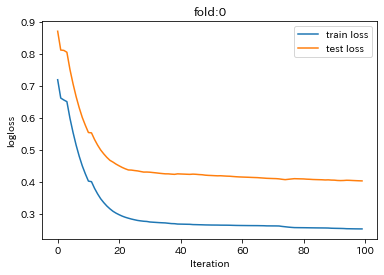

[I 2021-12-27 17:20:38,189] A new study created in memory with name: no-name-38e087c7-222d-4d93-986f-bc1f36eb81c6


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:38,761] Trial 0 finished with value: 0.10313165674393071 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133798	Test's rmse: 0.103132
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:39,230] Trial 1 finished with value: 0.12250201339158852 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131693	Test's rmse: 0.122502
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:39,575] Trial 2 finished with value: 0.11199663372018692 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:39,973] Trial 3 finished with value: 0.10522738562850059 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144067	Test's rmse: 0.105227
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:40,294] Trial 4 finished with value: 0.13184108603175235 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136538	Test's rmse: 0.131841
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:40,588] Trial 5 finished with value: 0.10804926853338176 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134845	Test's rmse: 0.108049
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:40,920] Trial 6 finished with value: 0.11941999345239779 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.10313165674393071.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130288	Test's rmse: 0.11942
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:42,269] Trial 7 finished with value: 0.11628200345260703 and parameters: {'num_leaves': 223}. Best is trial 7 with value: 0.11628200345260703.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137189	Test's rmse: 0.116282
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:43,286] Trial 8 finished with value: 0.11401743352056289 and parameters: {'num_leaves': 160}. Best is trial 8 with value: 0.11401743352056289.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137093	Test's rmse: 0.114017
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:20:44,709] Trial 9 finished with value: 0.11623329404942634 and parameters: {'num_leaves': 236}. Best is trial 8 with value: 0.11401743352056289.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136763	Test's rmse: 0.116233
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:46,246] Trial 10 finished with value: 0.11342893530789282 and parameters: {'num_leaves': 182}. Best is trial 10 with value: 0.11342893530789282.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136528	Test's rmse: 0.113429
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:46,870] Trial 11 finished with value: 0.10899431406751013 and parameters: {'num_leaves': 87}. Best is trial 11 with value: 0.10899431406751013.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138431	Test's rmse: 0.108994
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:48,332] Trial 12 finished with value: 0.11372642871244107 and parameters: {'num_leaves': 138}. Best is trial 11 with value: 0.10899431406751013.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137885	Test's rmse: 0.113726
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:48,796] Trial 13 finished with value: 0.10222564455515867 and parameters: {'num_leaves': 51}. Best is trial 13 with value: 0.10222564455515867.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136753	Test's rmse: 0.102226
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1399	Test's rmse: 0.100422


[I 2021-12-27 17:20:48,967] Trial 14 finished with value: 0.10042184465499364 and parameters: {'num_leaves': 12}. Best is trial 14 with value: 0.10042184465499364.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:50,013] Trial 15 finished with value: 0.1147745571803978 and parameters: {'num_leaves': 153}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136423	Test's rmse: 0.114775
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:50,946] Trial 16 finished with value: 0.11362483669880624 and parameters: {'num_leaves': 156}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135526	Test's rmse: 0.113625
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.216068	Test's rmse: 0.123493


[I 2021-12-27 17:20:51,066] Trial 17 finished with value: 0.12349274626533661 and parameters: {'num_leaves': 2}. Best is trial 14 with value: 0.10042184465499364.
[I 2021-12-27 17:20:51,258] Trial 18 finished with value: 0.10286341207405077 and parameters: {'num_leaves': 14}. Best is trial 14 with value: 0.10042184465499364.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140106	Test's rmse: 0.102863
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:51,751] Trial 19 finished with value: 0.10640269929787384 and parameters: {'num_leaves': 65}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136363	Test's rmse: 0.106403
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:52,169] Trial 20 finished with value: 0.1044161084925442 and parameters: {'num_leaves': 55}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135091	Test's rmse: 0.104416
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:52,502] Trial 21 finished with value: 0.10645611370855404 and parameters: {'num_leaves': 41}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137238	Test's rmse: 0.106456
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:53,189] Trial 22 finished with value: 0.11106053805662955 and parameters: {'num_leaves': 99}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137626	Test's rmse: 0.111061
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:53,413] Trial 23 finished with value: 0.10169827359096138 and parameters: {'num_leaves': 28}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139471	Test's rmse: 0.101698
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:53,962] Trial 24 finished with value: 0.11132230154414344 and parameters: {'num_leaves': 103}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138482	Test's rmse: 0.111322
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:54,199] Trial 25 finished with value: 0.10469635960859616 and parameters: {'num_leaves': 25}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136136	Test's rmse: 0.104696
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:54,655] Trial 26 finished with value: 0.10901222057718436 and parameters: {'num_leaves': 78}. Best is trial 14 with value: 0.10042184465499364.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139114	Test's rmse: 0.109012
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140332	Test's rmse: 0.109579


[I 2021-12-27 17:20:54,826] Trial 27 finished with value: 0.10957938763261224 and parameters: {'bagging_fraction': 0.9742127818817934, 'bagging_freq': 6}. Best is trial 27 with value: 0.10957938763261224.
[I 2021-12-27 17:20:54,984] Trial 28 finished with value: 0.12369837452833106 and parameters: {'bagging_fraction': 0.533895418107775, 'bagging_freq': 5}. Best is trial 27 with value: 0.10957938763261224.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183114	Test's rmse: 0.123698
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:55,150] Trial 29 finished with value: 0.12364645879717404 and parameters: {'bagging_fraction': 0.7011643200143305, 'bagging_freq': 4}. Best is trial 27 with value: 0.10957938763261224.
[I 2021-12-27 17:20:55,300] Trial 30 finished with value: 0.10738789630035943 and parameters: {'bagging_fraction': 0.646575907912387, 'bagging_freq': 1}. Best is trial 30 with value: 0.10738789630035943.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174689	Test's rmse: 0.123646
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172196	Test's rmse: 0.107388
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:55,488] Trial 31 finished with value: 0.11041894195207896 and parameters: {'bagging_fraction': 0.5815456114694273, 'bagging_freq': 1}. Best is trial 30 with value: 0.10738789630035943.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178974	Test's rmse: 0.110419
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:55,679] Trial 32 finished with value: 0.11161111981502773 and parameters: {'bagging_fraction': 0.8978271737730266, 'bagging_freq': 6}. Best is trial 30 with value: 0.10738789630035943.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154703	Test's rmse: 0.111611
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:55,873] Trial 33 finished with value: 0.10600572355793542 and parameters: {'bagging_fraction': 0.8516261310025335, 'bagging_freq': 3}. Best is trial 33 with value: 0.10600572355793542.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156342	Test's rmse: 0.106006
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:56,052] Trial 34 finished with value: 0.13155379373401674 and parameters: {'bagging_fraction': 0.4549435045861456, 'bagging_freq': 4}. Best is trial 33 with value: 0.10600572355793542.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.189834	Test's rmse: 0.131554
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808


[I 2021-12-27 17:20:56,252] Trial 35 finished with value: 0.11199177557827009 and parameters: {'bagging_fraction': 0.9630116488588361, 'bagging_freq': 4}. Best is trial 33 with value: 0.10600572355793542.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145663	Test's rmse: 0.111992
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808


[I 2021-12-27 17:20:56,435] Trial 36 finished with value: 0.1088097699063265 and parameters: {'bagging_fraction': 0.8959926257276467, 'bagging_freq': 3}. Best is trial 33 with value: 0.10600572355793542.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151317	Test's rmse: 0.10881
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808


[I 2021-12-27 17:20:56,598] Trial 37 finished with value: 0.10866820697902006 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.10866820697902006.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133743	Test's rmse: 0.108668
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:56,736] Trial 38 finished with value: 0.1077345300306484 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.1077345300306484.
[I 2021-12-27 17:20:56,890] Trial 39 finished with value: 0.10021243025555954 and parameters: {'feature_fraction': 0.88}. Best is trial 39 with value: 0.10021243025555954.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132421	Test's rmse: 0.107735
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139753	Test's rmse: 0.100212
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:57,044] Trial 40 finished with value: 0.10042184465499364 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 39 with value: 0.10021243025555954.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1399	Test's rmse: 0.100422
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:57,189] Trial 41 finished with value: 0.10021243025555954 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 39 with value: 0.10021243025555954.
[I 2021-12-27 17:20:57,327] Trial 42 finished with value: 0.1077345300306484 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 39 with value: 0.10021243025555954.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139753	Test's rmse: 0.100212
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132421	Test's rmse: 0.107735
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:57,499] Trial 43 finished with value: 0.10021252614220935 and parameters: {'lambda_l1': 4.7439493855172935e-06, 'lambda_l2': 0.00022072532593280517}. Best is trial 43 with value: 0.10021252614220935.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139753	Test's rmse: 0.100213
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:57,684] Trial 44 finished with value: 0.10052117016176886 and parameters: {'lambda_l1': 0.2364738213459445, 'lambda_l2': 0.027129382515693416}. Best is trial 43 with value: 0.10021252614220935.
[I 2021-12-27 17:20:57,852] Trial 45 finished with value: 0.11230733132993811 and parameters: {'lambda_l1': 5.065150967863028, 'lambda_l2': 2.052933459950087}. Best is trial 43 with value: 0.10021252614220935.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137209	Test's rmse: 0.100521
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149917	Test's rmse: 0.112307
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:58,011] Trial 46 finished with value: 0.10021243025593074 and parameters: {'lambda_l1': 7.790403492489804e-08, 'lambda_l2': 1.1615400543479437e-07}. Best is trial 46 with value: 0.10021243025593074.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139753	Test's rmse: 0.100212
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:58,187] Trial 47 finished with value: 0.10021274141099935 and parameters: {'lambda_l1': 0.00023299191223211357, 'lambda_l2': 0.000313668068207693}. Best is trial 46 with value: 0.10021243025593074.
[I 2021-12-27 17:20:58,347] Trial 48 finished with value: 0.10020355801798213 and parameters: {'lambda_l1': 0.0017382668308631207, 'lambda_l2': 0.0021639518353422822}. Best is trial 48 with value: 0.10020355801798213.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139754	Test's rmse: 0.100213
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139748	Test's rmse: 0.100204
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:58,501] Trial 49 finished with value: 0.1001842227834326 and parameters: {'lambda_l1': 0.2455123795033307, 'lambda_l2': 4.442814855919782e-06}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140382	Test's rmse: 0.100184
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:58,651] Trial 50 finished with value: 0.10251070435454643 and parameters: {'lambda_l1': 0.004264945355499071, 'lambda_l2': 1.0296629403080786}. Best is trial 49 with value: 0.1001842227834326.
[I 2021-12-27 17:20:58,814] Trial 51 finished with value: 0.10021247637474193 and parameters: {'lambda_l1': 4.1195259975313525e-07, 'lambda_l2': 0.00011029299129248884}. Best is trial 49 with value: 0.1001842227834326.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139917	Test's rmse: 0.102511
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139753	Test's rmse: 0.100212
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:58,990] Trial 52 finished with value: 0.10021244692957383 and parameters: {'lambda_l1': 2.1695218673409785e-05, 'lambda_l2': 1.4065268361519649e-08}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139753	Test's rmse: 0.100212
[LightGBM] [Info] Total Bins 2290


[I 2021-12-27 17:20:59,161] Trial 53 finished with value: 0.10311262302883153 and parameters: {'lambda_l1': 0.17574987167793782, 'lambda_l2': 2.4104862619067565e-06}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139154	Test's rmse: 0.103113
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808


[I 2021-12-27 17:20:59,319] Trial 54 finished with value: 0.10036489151692089 and parameters: {'lambda_l1': 0.0051533087241259065, 'lambda_l2': 4.035362655239806e-06}. Best is trial 49 with value: 0.1001842227834326.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139908	Test's rmse: 0.100365
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:20:59,507] Trial 55 finished with value: 0.10228920896869845 and parameters: {'lambda_l1': 0.010299374332281348, 'lambda_l2': 0.006010756810341835}. Best is trial 49 with value: 0.1001842227834326.
[I 2021-12-27 17:20:59,670] Trial 56 finished with value: 0.11006158813506936 and parameters: {'lambda_l1': 4.380471791709886, 'lambda_l2': 1.0165152542994883e-05}. Best is trial 49 with value: 0.1001842227834326.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140443	Test's rmse: 0.102289
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144708	Test's rmse: 0.110062


[I 2021-12-27 17:20:59,834] Trial 57 finished with value: 0.10155471984228152 and parameters: {'lambda_l1': 0.11279224544292464, 'lambda_l2': 0.013607944712160428}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14114	Test's rmse: 0.101555
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:00,008] Trial 58 finished with value: 0.10021298806517959 and parameters: {'lambda_l1': 0.0007207096777600271, 'lambda_l2': 7.806415034751664e-07}. Best is trial 49 with value: 0.1001842227834326.
[I 2021-12-27 17:21:00,168] Trial 59 finished with value: 0.10021360777045954 and parameters: {'lambda_l1': 8.53122607673852e-05, 'lambda_l2': 0.0026561538511873507}. Best is trial 49 with value: 0.1001842227834326.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139755	Test's rmse: 0.100213
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139756	Test's rmse: 0.100214


[I 2021-12-27 17:21:00,334] Trial 60 finished with value: 0.10285906951870293 and parameters: {'lambda_l1': 0.06359396451803762, 'lambda_l2': 0.13601819489496578}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133779	Test's rmse: 0.102859
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22


[I 2021-12-27 17:21:00,607] Trial 61 finished with value: 0.1050806660191672 and parameters: {'lambda_l1': 0.9797611503539613, 'lambda_l2': 1.9843043561627178e-05}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138716	Test's rmse: 0.105081


[I 2021-12-27 17:21:00,799] Trial 62 finished with value: 0.1002022575818568 and parameters: {'lambda_l1': 0.0010848540334359661, 'lambda_l2': 3.601602948060189e-05}. Best is trial 49 with value: 0.1001842227834326.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139742	Test's rmse: 0.100202


[I 2021-12-27 17:21:00,985] Trial 63 finished with value: 0.09847250828853338 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.09847250828853338.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0760405	Test's rmse: 0.0984725
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	Train's rmse: 0.260681	Test's rmse: 0.186719


[I 2021-12-27 17:21:01,221] Trial 64 finished with value: 0.18671884843151285 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.09847250828853338.
[I 2021-12-27 17:21:01,365] Trial 65 finished with value: 0.10186651031805836 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.09847250828853338.


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	Train's rmse: 0.0763425	Test's rmse: 0.101867
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:01,523] Trial 66 finished with value: 0.11469598207122003 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.09847250828853338.
[I 2021-12-27 17:21:01,662] Trial 67 finished with value: 0.22691709453129122 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.09847250828853338.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162065	Test's rmse: 0.114696
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	Train's rmse: 0.336896	Test's rmse: 0.226917


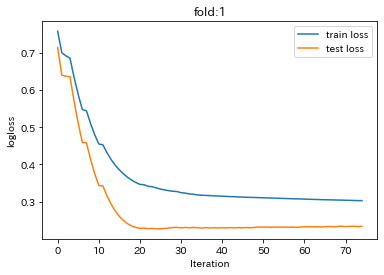

[I 2021-12-27 17:21:01,860] A new study created in memory with name: no-name-41b743e0-897a-4e0d-bc13-f83a76d0ed29


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134967	Test's rmse: 0.169026


[I 2021-12-27 17:21:02,090] Trial 0 finished with value: 0.16902597277644246 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.16902597277644246.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12905	Test's rmse: 0.149363


[I 2021-12-27 17:21:02,331] Trial 1 finished with value: 0.14936328917663394 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.14936328917663394.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14443	Test's rmse: 0.139906


[I 2021-12-27 17:21:02,572] Trial 2 finished with value: 0.1399063359860016 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.1399063359860016.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155903	Test's rmse: 0.140315


[I 2021-12-27 17:21:02,823] Trial 3 finished with value: 0.14031536940373338 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.1399063359860016.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:03,124] Trial 4 finished with value: 0.16057600609609454 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129464	Test's rmse: 0.160576
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:03,365] Trial 5 finished with value: 0.1415026234343981 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:03,617] Trial 6 finished with value: 0.1593121386019105 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.1399063359860016.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128939	Test's rmse: 0.159312
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:04,406] Trial 7 finished with value: 0.1421114771664161 and parameters: {'num_leaves': 153}. Best is trial 7 with value: 0.1421114771664161.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139672	Test's rmse: 0.142111
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:04,777] Trial 8 finished with value: 0.14307325421047107 and parameters: {'num_leaves': 63}. Best is trial 7 with value: 0.1421114771664161.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144556	Test's rmse: 0.143073
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:05,162] Trial 9 finished with value: 0.14050730894864435 and parameters: {'num_leaves': 60}. Best is trial 9 with value: 0.14050730894864435.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142887	Test's rmse: 0.140507
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:06,034] Trial 10 finished with value: 0.1439917606168839 and parameters: {'num_leaves': 174}. Best is trial 9 with value: 0.14050730894864435.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14106	Test's rmse: 0.143992
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:06,478] Trial 11 finished with value: 0.13968290115779555 and parameters: {'num_leaves': 77}. Best is trial 11 with value: 0.13968290115779555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143534	Test's rmse: 0.139683
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:07,276] Trial 12 finished with value: 0.14450322726892495 and parameters: {'num_leaves': 152}. Best is trial 11 with value: 0.13968290115779555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144254	Test's rmse: 0.144503
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:07,999] Trial 13 finished with value: 0.1417515098124393 and parameters: {'num_leaves': 126}. Best is trial 11 with value: 0.13968290115779555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141575	Test's rmse: 0.141752
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:08,190] Trial 14 finished with value: 0.13853218890024574 and parameters: {'num_leaves': 15}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14426	Test's rmse: 0.138532
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:21:09,403] Trial 15 finished with value: 0.14521333565861697 and parameters: {'num_leaves': 250}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142533	Test's rmse: 0.145213
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:09,675] Trial 16 finished with value: 0.13922569217350136 and parameters: {'num_leaves': 37}. Best is trial 14 with value: 0.13853218890024574.
[I 2021-12-27 17:21:09,763] Trial 17 finished with value: 0.16837132603841196 and parameters: {'num_leaves': 2}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137652	Test's rmse: 0.139226
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.210074	Test's rmse: 0.168371
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161555	Test's rmse: 0.15101


[I 2021-12-27 17:21:09,872] Trial 18 finished with value: 0.15101032941010567 and parameters: {'num_leaves': 5}. Best is trial 14 with value: 0.13853218890024574.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:10,188] Trial 19 finished with value: 0.14050705144273173 and parameters: {'num_leaves': 40}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140018	Test's rmse: 0.140507
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:10,726] Trial 20 finished with value: 0.14003393165701522 and parameters: {'num_leaves': 100}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143281	Test's rmse: 0.140034
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:10,965] Trial 21 finished with value: 0.1399063359860016 and parameters: {'num_leaves': 31}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14443	Test's rmse: 0.139906
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:11,460] Trial 22 finished with value: 0.14238561293902535 and parameters: {'num_leaves': 94}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142695	Test's rmse: 0.142386
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:12,494] Trial 23 finished with value: 0.14444906676910416 and parameters: {'num_leaves': 213}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141258	Test's rmse: 0.144449
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:12,817] Trial 24 finished with value: 0.13868893202154875 and parameters: {'num_leaves': 36}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137875	Test's rmse: 0.138689
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:13,061] Trial 25 finished with value: 0.1418416262375462 and parameters: {'num_leaves': 19}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142096	Test's rmse: 0.141842
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:13,750] Trial 26 finished with value: 0.14003393165701522 and parameters: {'num_leaves': 100}. Best is trial 14 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143281	Test's rmse: 0.140034
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:14,047] Trial 27 finished with value: 0.14996739895407504 and parameters: {'bagging_fraction': 0.5015001108154533, 'bagging_freq': 7}. Best is trial 27 with value: 0.14996739895407504.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182712	Test's rmse: 0.149967
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:14,296] Trial 28 finished with value: 0.1619050169436129 and parameters: {'bagging_fraction': 0.49701873754609327, 'bagging_freq': 3}. Best is trial 27 with value: 0.14996739895407504.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.181122	Test's rmse: 0.161905
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:14,526] Trial 29 finished with value: 0.1621995915757472 and parameters: {'bagging_fraction': 0.667336587605025, 'bagging_freq': 4}. Best is trial 27 with value: 0.14996739895407504.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173388	Test's rmse: 0.1622
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:14,762] Trial 30 finished with value: 0.1581044067145471 and parameters: {'bagging_fraction': 0.4044782520265916, 'bagging_freq': 5}. Best is trial 27 with value: 0.14996739895407504.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179329	Test's rmse: 0.158104
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:15,043] Trial 31 finished with value: 0.1454874741023422 and parameters: {'bagging_fraction': 0.969571829909681, 'bagging_freq': 5}. Best is trial 31 with value: 0.1454874741023422.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141852	Test's rmse: 0.145487
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:15,260] Trial 32 finished with value: 0.16096710309112106 and parameters: {'bagging_fraction': 0.49846379457671564, 'bagging_freq': 3}. Best is trial 31 with value: 0.1454874741023422.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180753	Test's rmse: 0.160967
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:15,517] Trial 33 finished with value: 0.14592961354267028 and parameters: {'bagging_fraction': 0.978425897215141, 'bagging_freq': 5}. Best is trial 31 with value: 0.1454874741023422.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14316	Test's rmse: 0.14593
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:15,751] Trial 34 finished with value: 0.14757495806137802 and parameters: {'bagging_fraction': 0.8268131054195761, 'bagging_freq': 3}. Best is trial 31 with value: 0.1454874741023422.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15906	Test's rmse: 0.147575
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:15,996] Trial 35 finished with value: 0.14671947590999906 and parameters: {'bagging_fraction': 0.9047081248108954, 'bagging_freq': 7}. Best is trial 31 with value: 0.1454874741023422.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146891	Test's rmse: 0.146719
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:16,260] Trial 36 finished with value: 0.14717013998592418 and parameters: {'bagging_fraction': 0.7030786702630316, 'bagging_freq': 2}. Best is trial 31 with value: 0.1454874741023422.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164917	Test's rmse: 0.14717
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:16,463] Trial 37 finished with value: 0.13853218890024574 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14426	Test's rmse: 0.138532
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:16,681] Trial 38 finished with value: 0.1462183960715439 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.13853218890024574.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128812	Test's rmse: 0.146218
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140806	Test's rmse: 0.140768


[I 2021-12-27 17:21:16,874] Trial 39 finished with value: 0.14076829984559736 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.13853218890024574.
[I 2021-12-27 17:21:17,048] Trial 40 finished with value: 0.14076829984559736 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.13853218890024574.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140806	Test's rmse: 0.140768
[LightGBM] [Info] Total Bins 2286


[I 2021-12-27 17:21:17,261] Trial 41 finished with value: 0.13696087913852567 and parameters: {'feature_fraction': 0.784}. Best is trial 41 with value: 0.13696087913852567.


[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Info] Total Bins 2286


[I 2021-12-27 17:21:17,460] Trial 42 finished with value: 0.13696087913852567 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 41 with value: 0.13696087913852567.


[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 17:21:17,665] Trial 43 finished with value: 0.1459318285115967 and parameters: {'lambda_l1': 1.644946542557523, 'lambda_l2': 0.05718003935065542}. Best is trial 43 with value: 0.1459318285115967.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131968	Test's rmse: 0.145932
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:17,905] Trial 44 finished with value: 0.13927297436165254 and parameters: {'lambda_l1': 0.0019072086612151697, 'lambda_l2': 1.594952448682783e-05}. Best is trial 44 with value: 0.13927297436165254.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139127	Test's rmse: 0.139273
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142057	Test's rmse: 0.152193


[I 2021-12-27 17:21:18,114] Trial 45 finished with value: 0.15219340047120086 and parameters: {'lambda_l1': 4.20110422603108, 'lambda_l2': 0.003156335858814799}. Best is trial 44 with value: 0.13927297436165254.
[I 2021-12-27 17:21:18,321] Trial 46 finished with value: 0.15066418512363836 and parameters: {'lambda_l1': 1.408423432230737e-07, 'lambda_l2': 5.2199170475436}. Best is trial 44 with value: 0.13927297436165254.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144867	Test's rmse: 0.150664


[I 2021-12-27 17:21:18,495] Trial 47 finished with value: 0.13927278226182627 and parameters: {'lambda_l1': 0.0017794292367931165, 'lambda_l2': 1.0146389634017966e-05}. Best is trial 47 with value: 0.13927278226182627.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139127	Test's rmse: 0.139273
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112


[I 2021-12-27 17:21:18,698] Trial 48 finished with value: 0.13696129737483706 and parameters: {'lambda_l1': 5.964901606050951e-06, 'lambda_l2': 0.0007073570071032332}. Best is trial 48 with value: 0.13696129737483706.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136005	Test's rmse: 0.136961
[LightGBM] [Info] Total Bins 2286


[I 2021-12-27 17:21:18,895] Trial 49 finished with value: 0.14274524831932558 and parameters: {'lambda_l1': 0.02608823946324959, 'lambda_l2': 2.6254232253836574e-06}. Best is trial 48 with value: 0.13696129737483706.


[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137159	Test's rmse: 0.142745
[LightGBM] [Info] Total Bins 2286


[I 2021-12-27 17:21:19,084] Trial 50 finished with value: 0.13696087917647662 and parameters: {'lambda_l1': 1.8509393744485375e-08, 'lambda_l2': 3.7723791997237694e-08}. Best is trial 50 with value: 0.13696087917647662.


[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138551	Test's rmse: 0.138739


[I 2021-12-27 17:21:19,299] Trial 51 finished with value: 0.13873914859964892 and parameters: {'lambda_l1': 0.0007084608695115143, 'lambda_l2': 0.0028381438777506595}. Best is trial 50 with value: 0.13696087917647662.
[I 2021-12-27 17:21:19,523] Trial 52 finished with value: 0.1466900493255829 and parameters: {'lambda_l1': 0.32922580713245436, 'lambda_l2': 1.5518448462695068e-07}. Best is trial 50 with value: 0.13696087917647662.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127901	Test's rmse: 0.14669


[I 2021-12-27 17:21:19,730] Trial 53 finished with value: 0.13696087916470917 and parameters: {'lambda_l1': 1.6223844282780904e-08, 'lambda_l2': 1.36225248827959e-08}. Best is trial 53 with value: 0.13696087916470917.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 17:21:19,976] Trial 54 finished with value: 0.1369608791703626 and parameters: {'lambda_l1': 1.8781417070876337e-08, 'lambda_l2': 1.1706589978458358e-08}. Best is trial 53 with value: 0.13696087916470917.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 17:21:20,214] Trial 55 finished with value: 0.13696088322079242 and parameters: {'lambda_l1': 2.6941588965305183e-06, 'lambda_l2': 1.1734346885087526e-08}. Best is trial 53 with value: 0.13696087916470917.
[I 2021-12-27 17:21:20,425] Trial 56 finished with value: 0.13696087951588434 and parameters: {'lambda_l1': 1.2580481055162252e-08, 'lambda_l2': 5.263793110751769e-07}. Best is trial 53 with value: 0.13696087916470917.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 17:21:20,670] Trial 57 finished with value: 0.13696088367941237 and parameters: {'lambda_l1': 2.984770526719866e-06, 'lambda_l2': 1.7308934276681627e-08}. Best is trial 53 with value: 0.13696087916470917.
[I 2021-12-27 17:21:20,874] Trial 58 finished with value: 0.13696092452362993 and parameters: {'lambda_l1': 2.5428875968490865e-07, 'lambda_l2': 7.735122036885752e-05}. Best is trial 53 with value: 0.13696087916470917.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136955


[I 2021-12-27 17:21:21,098] Trial 59 finished with value: 0.13695461707342396 and parameters: {'lambda_l1': 2.799598232803193e-05, 'lambda_l2': 7.23368198413333e-07}. Best is trial 59 with value: 0.13695461707342396.
[I 2021-12-27 17:21:21,305] Trial 60 finished with value: 0.13696093137606527 and parameters: {'lambda_l1': 3.560760047368349e-05, 'lambda_l2': 4.3420375355503646e-07}. Best is trial 59 with value: 0.13695461707342396.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136004	Test's rmse: 0.136961


[I 2021-12-27 17:21:21,518] Trial 61 finished with value: 0.13873665541919 and parameters: {'lambda_l1': 8.018590816077544e-05, 'lambda_l2': 1.9072954239758344e-06}. Best is trial 59 with value: 0.13695461707342396.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138545	Test's rmse: 0.138737


[I 2021-12-27 17:21:21,735] Trial 62 finished with value: 0.13801275110062114 and parameters: {'lambda_l1': 0.03766572034095887, 'lambda_l2': 1.3823970436849839e-07}. Best is trial 59 with value: 0.13695461707342396.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127066	Test's rmse: 0.138013


[I 2021-12-27 17:21:21,931] Trial 63 finished with value: 0.1544836347634357 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.1544836347634357.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0402288	Test's rmse: 0.154484
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22


[I 2021-12-27 17:21:22,105] Trial 64 finished with value: 0.1548240874740587 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.1544836347634357.


[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	Train's rmse: 0.117658	Test's rmse: 0.154824
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:22,328] Trial 65 finished with value: 0.1950849855466558 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.1544836347634357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.284769	Test's rmse: 0.195085
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147657	Test's rmse: 0.151099


[I 2021-12-27 17:21:22,536] Trial 66 finished with value: 0.15109946516746728 and parameters: {'min_child_samples': 25}. Best is trial 66 with value: 0.15109946516746728.
[I 2021-12-27 17:21:22,733] Trial 67 finished with value: 0.17486190574007157 and parameters: {'min_child_samples': 50}. Best is trial 66 with value: 0.15109946516746728.


[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.224713	Test's rmse: 0.174862


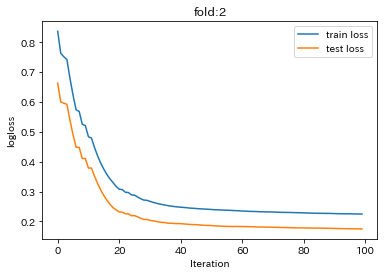

[I 2021-12-27 17:21:22,929] A new study created in memory with name: no-name-cf422b36-f66c-46f6-b058-0a4f374fea0f


[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:23,198] Trial 0 finished with value: 0.09305587411644023 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.09305587411644023.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136853	Test's rmse: 0.0930559
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:23,488] Trial 1 finished with value: 0.09014609510889711 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.09014609510889711.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126647	Test's rmse: 0.0901461
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:23,792] Trial 2 finished with value: 0.0830657271294555 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.0830657271294555.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133355	Test's rmse: 0.0830657
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:24,062] Trial 3 finished with value: 0.021772541083253553 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.021772541083253553.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:24,348] Trial 4 finished with value: 0.05415092072554367 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.021772541083253553.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144156	Test's rmse: 0.0541509
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:24,634] Trial 5 finished with value: 0.04017005974914526 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.021772541083253553.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150344	Test's rmse: 0.0401701
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:24,962] Trial 6 finished with value: 0.08032294115549551 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.021772541083253553.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129613	Test's rmse: 0.0803229
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:25,742] Trial 7 finished with value: 0.022024351773006056 and parameters: {'num_leaves': 149}. Best is trial 7 with value: 0.022024351773006056.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165361	Test's rmse: 0.0220244
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:26,678] Trial 8 finished with value: 0.02214941504547682 and parameters: {'num_leaves': 197}. Best is trial 7 with value: 0.022024351773006056.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165305	Test's rmse: 0.0221494
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:27,116] Trial 9 finished with value: 0.02205851737663938 and parameters: {'num_leaves': 67}. Best is trial 7 with value: 0.022024351773006056.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165307	Test's rmse: 0.0220585
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:27,993] Trial 10 finished with value: 0.022193267351301674 and parameters: {'num_leaves': 172}. Best is trial 7 with value: 0.022024351773006056.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164184	Test's rmse: 0.0221933
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:28,717] Trial 11 finished with value: 0.022090671873647705 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 0.022024351773006056.


Early stopping, best iteration is:
[45]	Train's rmse: 0.1653	Test's rmse: 0.0220907
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:29,386] Trial 12 finished with value: 0.022146945111498367 and parameters: {'num_leaves': 136}. Best is trial 7 with value: 0.022024351773006056.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165307	Test's rmse: 0.0221469
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:29,683] Trial 13 finished with value: 0.021355856313116782 and parameters: {'num_leaves': 42}. Best is trial 13 with value: 0.021355856313116782.


Early stopping, best iteration is:
[45]	Train's rmse: 0.167426	Test's rmse: 0.0213559
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:30,494] Trial 14 finished with value: 0.022069611691351205 and parameters: {'num_leaves': 141}. Best is trial 13 with value: 0.021355856313116782.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165305	Test's rmse: 0.0220696
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:31,330] Trial 15 finished with value: 0.02217938449803327 and parameters: {'num_leaves': 145}. Best is trial 13 with value: 0.021355856313116782.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165914	Test's rmse: 0.0221794
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:31,726] Trial 16 finished with value: 0.02166030689730755 and parameters: {'num_leaves': 65}. Best is trial 13 with value: 0.021355856313116782.
[I 2021-12-27 17:21:31,866] Trial 17 finished with value: 0.021676607732049248 and parameters: {'num_leaves': 9}. Best is trial 13 with value: 0.021355856313116782.


Early stopping, best iteration is:
[42]	Train's rmse: 0.166602	Test's rmse: 0.0216603
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	Train's rmse: 0.16391	Test's rmse: 0.0216766
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:32,210] Trial 18 finished with value: 0.021332257470692693 and parameters: {'num_leaves': 50}. Best is trial 18 with value: 0.021332257470692693.
[I 2021-12-27 17:21:32,352] Trial 19 finished with value: 0.021353008637956285 and parameters: {'num_leaves': 10}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[49]	Train's rmse: 0.164378	Test's rmse: 0.0213323
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992


[I 2021-12-27 17:21:32,484] Trial 20 finished with value: 0.021353008637956285 and parameters: {'num_leaves': 10}. Best is trial 18 with value: 0.021332257470692693.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:33,037] Trial 21 finished with value: 0.022202098883002296 and parameters: {'num_leaves': 95}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164232	Test's rmse: 0.0222021
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-12-27 17:21:34,224] Trial 22 finished with value: 0.02216108742731465 and parameters: {'num_leaves': 247}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221611
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:34,587] Trial 23 finished with value: 0.022576213146928235 and parameters: {'num_leaves': 39}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165029	Test's rmse: 0.0225762
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:35,190] Trial 24 finished with value: 0.02217489895672825 and parameters: {'num_leaves': 96}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166228	Test's rmse: 0.0221749
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:35,475] Trial 25 finished with value: 0.02149984367062733 and parameters: {'num_leaves': 36}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165638	Test's rmse: 0.0214998
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:35,965] Trial 26 finished with value: 0.021883500715414308 and parameters: {'num_leaves': 89}. Best is trial 18 with value: 0.021332257470692693.


Early stopping, best iteration is:
[42]	Train's rmse: 0.167427	Test's rmse: 0.0218835
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:36,315] Trial 27 finished with value: 0.02988748866004109 and parameters: {'bagging_fraction': 0.5345234043333473, 'bagging_freq': 2}. Best is trial 27 with value: 0.02988748866004109.


Early stopping, best iteration is:
[36]	Train's rmse: 0.19766	Test's rmse: 0.0298875
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:36,687] Trial 28 finished with value: 0.03763147055084386 and parameters: {'bagging_fraction': 0.5713780873168011, 'bagging_freq': 7}. Best is trial 27 with value: 0.02988748866004109.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182622	Test's rmse: 0.0376315
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:37,078] Trial 29 finished with value: 0.029068435866400236 and parameters: {'bagging_fraction': 0.8818101857031229, 'bagging_freq': 3}. Best is trial 29 with value: 0.029068435866400236.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170906	Test's rmse: 0.0290684
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:37,470] Trial 30 finished with value: 0.024079547210111487 and parameters: {'bagging_fraction': 0.9227086022765377, 'bagging_freq': 3}. Best is trial 30 with value: 0.024079547210111487.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156661	Test's rmse: 0.0240795
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:37,869] Trial 31 finished with value: 0.028057993828815683 and parameters: {'bagging_fraction': 0.8865937713590524, 'bagging_freq': 6}. Best is trial 30 with value: 0.024079547210111487.


Early stopping, best iteration is:
[48]	Train's rmse: 0.183389	Test's rmse: 0.028058
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:38,251] Trial 32 finished with value: 0.024336750425814443 and parameters: {'bagging_fraction': 0.897205034727268, 'bagging_freq': 1}. Best is trial 30 with value: 0.024079547210111487.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160865	Test's rmse: 0.0243368
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:38,648] Trial 33 finished with value: 0.025183891107170002 and parameters: {'bagging_fraction': 0.8990507185246878, 'bagging_freq': 5}. Best is trial 30 with value: 0.024079547210111487.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16611	Test's rmse: 0.0251839
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:38,990] Trial 34 finished with value: 0.027661715092649978 and parameters: {'bagging_fraction': 0.828598765182718, 'bagging_freq': 2}. Best is trial 30 with value: 0.024079547210111487.


Early stopping, best iteration is:
[38]	Train's rmse: 0.193733	Test's rmse: 0.0276617
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:39,402] Trial 35 finished with value: 0.03454039223877992 and parameters: {'bagging_fraction': 0.8517169180827477, 'bagging_freq': 3}. Best is trial 30 with value: 0.024079547210111487.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171552	Test's rmse: 0.0345404
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:39,802] Trial 36 finished with value: 0.021111928820782916 and parameters: {'bagging_fraction': 0.9936511110547593, 'bagging_freq': 6}. Best is trial 36 with value: 0.021111928820782916.


Early stopping, best iteration is:
[47]	Train's rmse: 0.165836	Test's rmse: 0.0211119
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:40,255] Trial 37 finished with value: 0.04374830741293566 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.04374830741293566.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149282	Test's rmse: 0.0437483
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:40,669] Trial 38 finished with value: 0.021111928820782916 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.021111928820782916.


Early stopping, best iteration is:
[47]	Train's rmse: 0.165836	Test's rmse: 0.0211119
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:41,185] Trial 39 finished with value: 0.0442757279305027 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.021111928820782916.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154044	Test's rmse: 0.0442757
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:41,614] Trial 40 finished with value: 0.020511688106954223 and parameters: {'lambda_l1': 0.00035342865084561924, 'lambda_l2': 2.420691275610259e-07}. Best is trial 40 with value: 0.020511688106954223.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167486	Test's rmse: 0.0205117
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:21:41,971] Trial 41 finished with value: 0.01980554708817279 and parameters: {'lambda_l1': 0.587143487678606, 'lambda_l2': 0.0003298994977009292}. Best is trial 41 with value: 0.01980554708817279.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:42,419] Trial 42 finished with value: 0.023068282968495786 and parameters: {'lambda_l1': 0.015434860929825355, 'lambda_l2': 5.258497834707134}. Best is trial 41 with value: 0.01980554708817279.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151971	Test's rmse: 0.0230683
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:42,854] Trial 43 finished with value: 0.021193761818063244 and parameters: {'lambda_l1': 4.373534750344321e-05, 'lambda_l2': 1.7245701215272796e-05}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[43]	Train's rmse: 0.167511	Test's rmse: 0.0211938
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:21:43,146] Trial 44 finished with value: 0.019806404887838254 and parameters: {'lambda_l1': 2.381238344886096, 'lambda_l2': 3.3711051414266215e-08}. Best is trial 41 with value: 0.01980554708817279.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:43,661] Trial 45 finished with value: 0.02129263789463681 and parameters: {'lambda_l1': 7.874258648340081e-07, 'lambda_l2': 0.0023119364442807594}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[47]	Train's rmse: 0.167301	Test's rmse: 0.0212926
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:44,142] Trial 46 finished with value: 0.022070002292246305 and parameters: {'lambda_l1': 0.0009898547925470606, 'lambda_l2': 0.019505733300550308}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165938	Test's rmse: 0.02207
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:44,668] Trial 47 finished with value: 0.021670396067452673 and parameters: {'lambda_l1': 0.0006078135405205999, 'lambda_l2': 5.481126167813038e-07}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[46]	Train's rmse: 0.167401	Test's rmse: 0.0216704
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:45,130] Trial 48 finished with value: 0.022065637599150745 and parameters: {'lambda_l1': 0.0008103756752611487, 'lambda_l2': 1.614510656728349e-08}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[43]	Train's rmse: 0.167531	Test's rmse: 0.0220656
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:21:45,499] Trial 49 finished with value: 0.020570573289039884 and parameters: {'lambda_l1': 0.6014488784728869, 'lambda_l2': 0.0003865594199543076}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[47]	Train's rmse: 0.163858	Test's rmse: 0.0205706
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:46,030] Trial 50 finished with value: 0.02638533195643033 and parameters: {'lambda_l1': 1.142804257795714e-08, 'lambda_l2': 0.42278148380347713}. Best is trial 41 with value: 0.01980554708817279.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150282	Test's rmse: 0.0263853
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2021-12-27 17:21:46,243] Trial 51 finished with value: 0.028529699251367953 and parameters: {'lambda_l1': 8.208874614838177, 'lambda_l2': 1.3129889360924668e-05}. Best is trial 41 with value: 0.01980554708817279.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:46,635] Trial 52 finished with value: 0.02058651486046187 and parameters: {'lambda_l1': 0.08679155873359143, 'lambda_l2': 2.0214472009476633e-05}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165784	Test's rmse: 0.0205865
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:21:46,865] Trial 53 finished with value: 0.020506248552482127 and parameters: {'lambda_l1': 3.552845106162809, 'lambda_l2': 0.03383972600523627}. Best is trial 41 with value: 0.01980554708817279.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:47,260] Trial 54 finished with value: 0.021420068893936217 and parameters: {'lambda_l1': 0.08320929622506758, 'lambda_l2': 1.535753496179102e-08}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[47]	Train's rmse: 0.163262	Test's rmse: 0.0214201
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:21:47,580] Trial 55 finished with value: 0.024946716640232347 and parameters: {'lambda_l1': 0.7065644929450176, 'lambda_l2': 1.2127446779452848e-06}. Best is trial 41 with value: 0.01980554708817279.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:47,959] Trial 56 finished with value: 0.02161559212145763 and parameters: {'lambda_l1': 0.0367520168132472, 'lambda_l2': 0.0002566552957007417}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166888	Test's rmse: 0.0216156
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:48,374] Trial 57 finished with value: 0.02119318460776345 and parameters: {'lambda_l1': 7.200064013440044e-06, 'lambda_l2': 0.0002303814915441166}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[43]	Train's rmse: 0.167511	Test's rmse: 0.0211932
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:48,842] Trial 58 finished with value: 0.021301642988764587 and parameters: {'lambda_l1': 0.009240804964399949, 'lambda_l2': 0.022110925626663787}. Best is trial 41 with value: 0.01980554708817279.


Early stopping, best iteration is:
[48]	Train's rmse: 0.165271	Test's rmse: 0.0213016
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2021-12-27 17:21:49,168] Trial 59 finished with value: 0.020510654077396665 and parameters: {'lambda_l1': 0.735221446520545, 'lambda_l2': 2.2061961709352095e-06}. Best is trial 41 with value: 0.01980554708817279.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:49,482] Trial 60 finished with value: 0.026312621247790123 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.026312621247790123.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:49,730] Trial 61 finished with value: 0.05513880140302135 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.026312621247790123.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-12-27 17:21:50,003] Trial 62 finished with value: 0.08629783524106108 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.026312621247790123.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.292963	Test's rmse: 0.0862978


[I 2021-12-27 17:21:50,374] Trial 63 finished with value: 0.02362705096285662 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.02362705096285662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0217359	Test's rmse: 0.0236271
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't impro

[I 2021-12-27 17:21:50,685] Trial 64 finished with value: 0.02655349619239846 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.02362705096285662.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

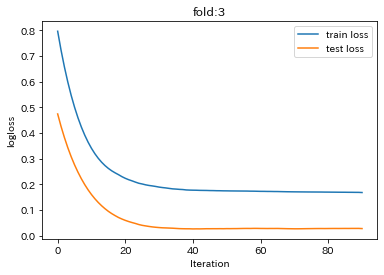

[I 2021-12-27 17:21:50,933] A new study created in memory with name: no-name-139bd9fc-b4e0-4c1c-9b11-ec6f59f29e65


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:51,205] Trial 0 finished with value: 0.3912741168845798 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.3912741168845798.


Early stopping, best iteration is:
[42]	Train's rmse: 0.154665	Test's rmse: 0.391274
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:51,510] Trial 1 finished with value: 0.3730328037776354 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.3730328037776354.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:51,785] Trial 2 finished with value: 0.41867181945067966 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121956	Test's rmse: 0.418672
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:52,139] Trial 3 finished with value: 0.41192885012396424 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121667	Test's rmse: 0.411929
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:52,415] Trial 4 finished with value: 0.4177141650444445 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122753	Test's rmse: 0.417714
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:52,644] Trial 5 finished with value: 0.3786815048787219 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.3730328037776354.


Early stopping, best iteration is:
[37]	Train's rmse: 0.15737	Test's rmse: 0.378682
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:52,916] Trial 6 finished with value: 0.4174154758767119 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.3730328037776354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120118	Test's rmse: 0.417415
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:53,822] Trial 7 finished with value: 0.3760705799703968 and parameters: {'num_leaves': 177}. Best is trial 7 with value: 0.3760705799703968.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159185	Test's rmse: 0.376071
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:54,338] Trial 8 finished with value: 0.37606538277024276 and parameters: {'num_leaves': 111}. Best is trial 8 with value: 0.37606538277024276.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376065
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:54,753] Trial 9 finished with value: 0.37321050311229975 and parameters: {'num_leaves': 42}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[33]	Train's rmse: 0.15726	Test's rmse: 0.373211
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:55,727] Trial 10 finished with value: 0.37606409659409157 and parameters: {'num_leaves': 238}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:56,423] Trial 11 finished with value: 0.37606536703168325 and parameters: {'num_leaves': 112}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376065
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:57,074] Trial 12 finished with value: 0.37608453726509516 and parameters: {'num_leaves': 156}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159181	Test's rmse: 0.376085
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:57,932] Trial 13 finished with value: 0.37606409114048667 and parameters: {'num_leaves': 227}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:58,312] Trial 14 finished with value: 0.3760689698429868 and parameters: {'num_leaves': 75}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159191	Test's rmse: 0.376069
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:58,907] Trial 15 finished with value: 0.37606942541592525 and parameters: {'num_leaves': 126}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159188	Test's rmse: 0.376069
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:59,233] Trial 16 finished with value: 0.37607894046702994 and parameters: {'num_leaves': 49}. Best is trial 9 with value: 0.37321050311229975.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159197	Test's rmse: 0.376079
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	Train's rmse: 0.159614	Test's rmse: 0.372108


[I 2021-12-27 17:21:59,424] Trial 17 finished with value: 0.37210844239304375 and parameters: {'num_leaves': 19}. Best is trial 17 with value: 0.37210844239304375.
[I 2021-12-27 17:21:59,565] Trial 18 finished with value: 0.37205648038214495 and parameters: {'num_leaves': 10}. Best is trial 18 with value: 0.37205648038214495.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.155658	Test's rmse: 0.372056
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:21:59,678] Trial 19 finished with value: 0.3433362732693353 and parameters: {'num_leaves': 3}. Best is trial 19 with value: 0.3433362732693353.
[I 2021-12-27 17:21:59,794] Trial 20 finished with value: 0.3671990559770216 and parameters: {'num_leaves': 9}. Best is trial 19 with value: 0.3433362732693353.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169751	Test's rmse: 0.343336
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	Train's rmse: 0.159293	Test's rmse: 0.367199
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:00,243] Trial 21 finished with value: 0.3760689698429868 and parameters: {'num_leaves': 75}. Best is trial 19 with value: 0.3433362732693353.
[I 2021-12-27 17:22:00,384] Trial 22 finished with value: 0.3542835198785773 and parameters: {'num_leaves': 6}. Best is trial 19 with value: 0.3433362732693353.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159191	Test's rmse: 0.376069
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	Train's rmse: 0.155086	Test's rmse: 0.354284
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:00,907] Trial 23 finished with value: 0.3761133924605221 and parameters: {'num_leaves': 67}. Best is trial 19 with value: 0.3433362732693353.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159226	Test's rmse: 0.376113
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:01,169] Trial 24 finished with value: 0.37209176003576927 and parameters: {'num_leaves': 39}. Best is trial 19 with value: 0.3433362732693353.
[I 2021-12-27 17:22:01,252] Trial 25 finished with value: 0.33782957159900123 and parameters: {'num_leaves': 2}. Best is trial 25 with value: 0.33782957159900123.


Early stopping, best iteration is:
[31]	Train's rmse: 0.159759	Test's rmse: 0.372092
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196657	Test's rmse: 0.33783
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:02,344] Trial 26 finished with value: 0.37576807781371324 and parameters: {'num_leaves': 200}. Best is trial 25 with value: 0.33782957159900123.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:02,506] Trial 27 finished with value: 0.3366391945252749 and parameters: {'bagging_fraction': 0.6301550917284493, 'bagging_freq': 3}. Best is trial 27 with value: 0.3366391945252749.
[I 2021-12-27 17:22:02,613] Trial 28 finished with value: 0.3295931094850455 and parameters: {'bagging_fraction': 0.5998972821745961, 'bagging_freq': 2}. Best is trial 28 with value: 0.3295931094850455.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19679	Test's rmse: 0.336639
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.196987	Test's rmse: 0.3361


[I 2021-12-27 17:22:02,703] Trial 29 finished with value: 0.3360995566685413 and parameters: {'bagging_fraction': 0.6952142107725694, 'bagging_freq': 7}. Best is trial 28 with value: 0.3295931094850455.
[I 2021-12-27 17:22:02,812] Trial 30 finished with value: 0.3387274513227662 and parameters: {'bagging_fraction': 0.6520909053642856, 'bagging_freq': 7}. Best is trial 28 with value: 0.3295931094850455.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.197074	Test's rmse: 0.338727
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196476	Test's rmse: 0.334096


[I 2021-12-27 17:22:02,916] Trial 31 finished with value: 0.3340963421561643 and parameters: {'bagging_fraction': 0.7549891893773104, 'bagging_freq': 3}. Best is trial 28 with value: 0.3295931094850455.
[I 2021-12-27 17:22:03,026] Trial 32 finished with value: 0.3328985316800606 and parameters: {'bagging_fraction': 0.7090333331137231, 'bagging_freq': 5}. Best is trial 28 with value: 0.3295931094850455.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[90]	Train's rmse: 0.196674	Test's rmse: 0.332899
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:03,126] Trial 33 finished with value: 0.3361267295958501 and parameters: {'bagging_fraction': 0.9730695437240277, 'bagging_freq': 5}. Best is trial 28 with value: 0.3295931094850455.
[I 2021-12-27 17:22:03,219] Trial 34 finished with value: 0.33677396048319186 and parameters: {'bagging_fraction': 0.6159032270390308, 'bagging_freq': 6}. Best is trial 28 with value: 0.3295931094850455.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196543	Test's rmse: 0.336127
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.196896	Test's rmse: 0.336774
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196296	Test's rmse: 0.334011


[I 2021-12-27 17:22:03,313] Trial 35 finished with value: 0.33401109414605057 and parameters: {'bagging_fraction': 0.9129239155741532, 'bagging_freq': 1}. Best is trial 28 with value: 0.3295931094850455.
[I 2021-12-27 17:22:03,415] Trial 36 finished with value: 0.3377658847767743 and parameters: {'bagging_fraction': 0.6860055217884173, 'bagging_freq': 2}. Best is trial 28 with value: 0.3295931094850455.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.19679	Test's rmse: 0.337766
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:03,589] Trial 37 finished with value: 0.3295931094850455 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 37 with value: 0.3295931094850455.
[I 2021-12-27 17:22:03,731] Trial 38 finished with value: 0.3309031172894006 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.3295931094850455.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.197178	Test's rmse: 0.330903
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22


[I 2021-12-27 17:22:03,868] Trial 39 finished with value: 0.3312675233192048 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 37 with value: 0.3295931094850455.


[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.196886	Test's rmse: 0.331268
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196686	Test's rmse: 0.330011


[I 2021-12-27 17:22:03,992] Trial 40 finished with value: 0.33001145879159793 and parameters: {'lambda_l1': 0.1571835289071164, 'lambda_l2': 0.1180037710436075}. Best is trial 40 with value: 0.33001145879159793.
[I 2021-12-27 17:22:04,101] Trial 41 finished with value: 0.32959507282546874 and parameters: {'lambda_l1': 6.533699625539197e-05, 'lambda_l2': 0.0027950454238434346}. Best is trial 41 with value: 0.32959507282546874.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329595
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:04,201] Trial 42 finished with value: 0.3295933175079731 and parameters: {'lambda_l1': 0.00022649518698602064, 'lambda_l2': 4.6519309205213333e-05}. Best is trial 42 with value: 0.3295933175079731.
[I 2021-12-27 17:22:04,310] Trial 43 finished with value: 0.3295933086980793 and parameters: {'lambda_l1': 0.0001902483538651214, 'lambda_l2': 7.455487462065767e-05}. Best is trial 43 with value: 0.3295933086980793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:04,410] Trial 44 finished with value: 0.33039762050950433 and parameters: {'lambda_l1': 0.0012380653689028755, 'lambda_l2': 1.8514319793735565}. Best is trial 43 with value: 0.3295933086980793.
[I 2021-12-27 17:22:04,525] Trial 45 finished with value: 0.3299008238220176 and parameters: {'lambda_l1': 0.01876656732873834, 'lambda_l2': 1.654113835809324e-06}. Best is trial 43 with value: 0.3295933086980793.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196809	Test's rmse: 0.330398
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196645	Test's rmse: 0.329901
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:04,629] Trial 46 finished with value: 0.33000125379496675 and parameters: {'lambda_l1': 0.07886978478696609, 'lambda_l2': 1.0439675635828485e-06}. Best is trial 43 with value: 0.3295933086980793.
[I 2021-12-27 17:22:04,733] Trial 47 finished with value: 0.3316936636550022 and parameters: {'lambda_l1': 0.00015974127011570433, 'lambda_l2': 7.341964646483273}. Best is trial 43 with value: 0.3295933086980793.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.196609	Test's rmse: 0.330001
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196675	Test's rmse: 0.331694
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:04,868] Trial 48 finished with value: 0.3295931118914731 and parameters: {'lambda_l1': 3.077043726416922e-07, 'lambda_l2': 3.0484307933622033e-06}. Best is trial 48 with value: 0.3295931118914731.
[I 2021-12-27 17:22:05,013] Trial 49 finished with value: 0.32959311217406684 and parameters: {'lambda_l1': 2.7770615914375166e-07, 'lambda_l2': 3.5960537732255053e-06}. Best is trial 48 with value: 0.3295931118914731.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287


[I 2021-12-27 17:22:05,189] Trial 50 finished with value: 0.32959310959185284 and parameters: {'lambda_l1': 1.0021108155412279e-08, 'lambda_l2': 5.597425864798084e-08}. Best is trial 50 with value: 0.32959310959185284.


[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462


[I 2021-12-27 17:22:05,310] Trial 51 finished with value: 0.3295931096573518 and parameters: {'lambda_l1': 1.2792542848007959e-08, 'lambda_l2': 9.306077190150265e-08}. Best is trial 50 with value: 0.32959310959185284.
[I 2021-12-27 17:22:05,435] Trial 52 finished with value: 0.32959310955042254 and parameters: {'lambda_l1': 4.211449331173414e-08, 'lambda_l2': 1.1740824703196285e-08}. Best is trial 52 with value: 0.32959310955042254.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593


[I 2021-12-27 17:22:05,544] Trial 53 finished with value: 0.3368235114636988 and parameters: {'lambda_l1': 7.066901286279201, 'lambda_l2': 2.1993442804336338e-08}. Best is trial 52 with value: 0.32959310955042254.


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197406	Test's rmse: 0.336824
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:05,669] Trial 54 finished with value: 0.32959310950293047 and parameters: {'lambda_l1': 2.5535502335794884e-08, 'lambda_l2': 1.0397798314637246e-08}. Best is trial 54 with value: 0.32959310950293047.
[I 2021-12-27 17:22:05,794] Trial 55 finished with value: 0.3295931111463796 and parameters: {'lambda_l1': 2.1512066291952462e-06, 'lambda_l2': 1.529768924047412e-08}. Best is trial 54 with value: 0.32959310950293047.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:05,903] Trial 56 finished with value: 0.32959539696166623 and parameters: {'lambda_l1': 1.7893122526749778e-06, 'lambda_l2': 0.0033412965177773597}. Best is trial 54 with value: 0.32959310950293047.
[I 2021-12-27 17:22:06,023] Trial 57 finished with value: 0.329593109780433 and parameters: {'lambda_l1': 7.574469056714427e-08, 'lambda_l2': 2.915764086366075e-07}. Best is trial 54 with value: 0.32959310950293047.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329595
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:06,131] Trial 58 finished with value: 0.32959313437643206 and parameters: {'lambda_l1': 6.910649606914288e-06, 'lambda_l2': 2.849249348219472e-05}. Best is trial 54 with value: 0.32959310950293047.
[I 2021-12-27 17:22:06,272] Trial 59 finished with value: 0.32959311589220447 and parameters: {'lambda_l1': 8.135003358482232e-06, 'lambda_l2': 1.0103425642474033e-08}. Best is trial 54 with value: 0.32959310950293047.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196712	Test's rmse: 0.329593
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22


[I 2021-12-27 17:22:06,412] Trial 60 finished with value: 0.3316578517079538 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.3316578517079538.


[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.196551	Test's rmse: 0.331658
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:06,537] Trial 61 finished with value: 0.33126972236194446 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.33126972236194446.
[I 2021-12-27 17:22:06,671] Trial 62 finished with value: 0.33122183173465247 and parameters: {'min_child_samples': 10}. Best is trial 62 with value: 0.33122183173465247.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.197384	Test's rmse: 0.33127
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196776	Test's rmse: 0.331222
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


[I 2021-12-27 17:22:06,798] Trial 63 finished with value: 0.5211377657274792 and parameters: {'min_child_samples': 100}. Best is trial 62 with value: 0.33122183173465247.
[I 2021-12-27 17:22:06,893] Trial 64 finished with value: 0.4273098014188009 and parameters: {'min_child_samples': 50}. Best is trial 62 with value: 0.33122183173465247.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.287654	Test's rmse: 0.521138
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.238035	Test's rmse: 0.42731


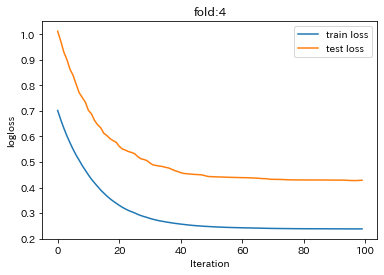

RMSE: [0.32027217120001295, 0.0984725082631906, 0.13695462000202005, 0.019805546283516814, 0.32959310978041356]
RMSE: 0.1810195911058308


In [6]:
start = time.time()

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': 'rmse',  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.LightGBMTuner(
                    params,                    # ハイパーパラメータをセット
                    train_set = lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    evals_result=lgb_results,
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    show_progress_bar = False,        # プログレスバーの非表示
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )
    
    # 訓練の実施
    model.run()

    best_params = model.best_params
    best_model = model.get_best_booster()

    pickle.dump(best_model, open(f"model_fold_{i}.pkl", 'wb')) # モデルの保存
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{i}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

elasped_time = round((time.time() - start), 1)

## モデルの読込

In [7]:
start_loaded = time.time()

cv_result_loaded = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    loaded_model = pickle.load(open(f"model_fold_{i}.pkl", 'rb'))
    y_pred = loaded_model.predict(X_test_gkf)

    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_loaded.append(rmse)

print("RMSE:", cv_result_loaded)
print("RMSE:", np.mean(cv_result_loaded))
elasped_time_loaded = round((time.time() - start_loaded), 1)

RMSE: [0.32027217120001295, 0.0984725082631906, 0.13695462000202005, 0.019805546283516814, 0.32959310978041356]
RMSE: 0.1810195911058308


In [8]:
print("RMSE:", np.mean(cv_result))
print(f"経過時間:{elasped_time}")

print("pickle読込 RMSE:", np.mean(cv_result_loaded))
print(f"pickle読込 経過時間:{elasped_time_loaded}")

RMSE: 0.1810195911058308
経過時間:123.8
pickle読込 RMSE: 0.1810195911058308
pickle読込 経過時間:0.1
